In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from deap import tools
import copy

# Imprimir melhor as tabelas
from tabulate import tabulate
#print(tabulate(distance_table,  tablefmt="grid"))

### Métodos do Caixeiro Viajante

In [2]:
def criar_cidades(N: int):
    x = np.random.rand(N)
    y = np.random.rand(N)
    return x, y 

def plot_cidades(x: np.ndarray, y: np.ndarray, print_coord: bool = False) -> None:
    for xi, yi in list(zip(x,y)):
        plt.scatter(xi, yi)
        if print_coord:
            print(xi, yi)

def make_caminhos(N: int, num_individuos: int) -> list[list]:
    cam = np.arange(N, dtype=np.int16)
    ncam = [cam.tolist()]
    # de 1 pois ja tem o caminho base incluso
    for k in range(1, num_individuos):
        vec_temp = cam.copy()
        random.shuffle(vec_temp)
        ncam.append(vec_temp)
    return ncam

def get_distance_table(N: int, x: np.ndarray, y: np.ndarray):
    # Tabela NxN
    distance_table = np.empty(shape=(N,N))
    for i in range(N):
        for j in range(N):
            distance_table[i][j] = np.sqrt( (x[i] - x[j])**2 + (y[i] - y[j])**2 )    
    return distance_table

def get_aptidao(N, numero_individuos, numero_caminhos, distance_table):
    aptidao = np.empty(numero_individuos)
    
    # para todos os genotipos/individuos
    for k in range(numero_individuos):
        aptidao[k] = 0
        # Percorrer as cidades (N-1 operações)
        for i in range(N-1):
            aptidao[k] += distance_table[ numero_caminhos[k][i], numero_caminhos[k][i+1] ]
        # retornar a cidade inicial
                                         # ultima cidade         # primeira
        aptidao[k] += distance_table[ numero_caminhos[k][N-1] , numero_caminhos[k][0] ]

    return aptidao

### Métodos do Algoritmo Genético : Mutação e Crossover  
Mecanismos de recombinação e mutação devem ser definidos com base na aptidão dos indivíduos.

In [3]:
def get_pais(aptidao: list, numero_caminhos: np.ndarray):
    # Cria uma shallow copy do array aptidao, com estas em ordem crescente
    aptidao_sorted = np.copy(aptidao)
    aptidao_sorted.sort()
    
    # Seleciona o valor dos caminhos do mais aptos
    min2 = aptidao_sorted[1]
    min1 = aptidao_sorted[0]
    
    # Cria um array para armazenar o indice dos mais aptos do array aptidao
    # que indexarao a escolha de caminho no array de caminhos
    pais_escolhidos = []
    
    for index, valor in enumerate(aptidao):
        #print("index, valor = ", (index,valor))
        if valor == min1 or valor == min2:
            pais_escolhidos.append(numero_caminhos[index])
        else:
            continue
    return pais_escolhidos

In [94]:
def reciprocal_exchange(filho: list) -> list | None:
    tamanho_filho = len(filho)
    i , j = np.random.choice(a=[i for i in range(tamanho_filho)], size=2 , replace=False)
    
    # print(f"Indices que irao trocar: {i=} {j=}")
    vec_copy = np.copy(filho)

    # print(f"Antes da inversao -> {filho} ")
    filho[i] = vec_copy[j]
    filho[j] = vec_copy[i]

    # print(f"Depois da inversao -> {filho}")
    return filho


**TO-DO**  

Cria duas classes:  
- **CrossOver**  
- **Mutacao**    

Os métodos da classe **CrossOver** serão:  
- OX $\rightarrow$ `tools.cxOrdered(pai1, pai2)`  
- PMX $\rightarrow$ `tools.cxPartialyMatched(pai1, pai2)`  
- Cycle $\rightarrow$ a implementar   

Os métodos da classe **Mutacao** serão:  
- inversão $\rightarrow$ utilizar o `tools.mutInversion(filho)`  
- reciprocal_exchange $\rightarrow$ já implementei

*Nota:* Quando for evoluir, verificar se esses métodos estão mantendo fixos o numero de indivíduos em cada geração, ou seja, o tamanho do array ncam tem que permanecer o mesmo.

In [61]:
class Crossover:
    def __init__(self, N):
        self.N = N

    @staticmethod
    def OrderOperator(pais: list[list], num_individuos) -> list | np.ndarray:
        """
        Aplica o método Order Operator sobre dois pais e retorna uma população de
        N individuos, [pai1, pai2, N-2].
        """
        numero_de_filhos = (num_individuos - 2) // 2
        pai1, pai2 = pais[0], pais[1]
        #print("pais: ", pai1, pai2 )
        
        # Criar cópias para nao sobrescrever o gene dos pais
        pai1_copy  =np.copy(pai1)
        pai2_copy = np.copy(pai2)
        filhos = [pai1, pai2]

        # Crossover
        for _ in range(numero_de_filhos):
            #print(f"{pai1_copy=}")
            #print(f"{pai2_copy=}")
            print()
            f1, f2 = tools.cxOrdered(pai1_copy, pai2_copy)
            filhos.append(f1)
            filhos.append(f2)
            #print("populacao", filhos)
        return filhos

    def PartiallyMatched(pais: list[list], num_individuos) -> list | np.ndarray:
        """
        Aplica o método PMX sobre dois pais e retorna uma população de
        N individuos, [pai1, pai2, N-2].
        """
        numero_de_filhos = (num_individuos - 2) // 2
        pai1, pai2 = pais[0], pais[1]
       # print("pais: ", pai1, pai2 )
        
        # Criar cópias para nao sobrescrever o gene dos pais
        pai1_copy  =copy.deepcopy(pai1)
        pai2_copy = copy.deepcopy(pai2)
        filhos = [pai1, pai2]

        # Crossover
        for _ in range(numero_de_filhos):
            #print(f"{pai1_copy=}")
            #print(f"{pai2_copy=}")
            #print()
            f1, f2 = tools.cxPartially(pai1_copy, pai2_copy)
            filhos.append(f1)
            filhos.append(f2)
            #print("populacao", filhos)
        return filhos
    

In [6]:
# ignorar cruzamento
def cruzamento(pais):
    ## pais= ncam
    num_filhos = len(pais) * 2
    filhos = []
    for i in range(0, len(pais), 2):
        pai1 = pais[i]
        pai2 = pais[i + 1]

        # algoritmo dos metodos três metodos de crossover, # TO-DO escolher um
        filho1 , filho2 = tools.cxOrdered(pai1, pai2) # OX
        # filho1 , filho2 = tools.cxPartialyMatched(pai1, pai2) # PMX
        # filho1 , filho2 = tools.cxCycle(pai1, pai2) # Cycle

        
        filhos.append(filho1)
        filhos.append(filho2)
    return filhos

def mutacao(filhos, taxa_mutacao=0.01, inversao: bool = True):
    # filho: list , filhos: list[list]
    
    for filho in filhos:
        if np.random.rand() < taxa_mutacao:
            
            if inversao:
            # algoritmo de mutacao (Reciprocal Exchange e Inversion)
                filho, = tools.mutInversion(filho)
            else:
                filho = reciprocal_exchange(filho)
    return filhos

def main_evolucao(N, num_individuos, num_geracoes, x, y):
    distance_table = get_distance_table(N, x, y)
    numero_caminhos = make_caminhos(N, num_individuos)
    
    dist_min = []
    
    for geracao in range(num_geracoes):
        aptidao = get_aptidao(N, num_individuos, numero_caminhos, distance_table)
        # 
        dist_min.append(np.min(aptidao))
        # Determinar os pais 
        pais = get_pais(aptidao=aptidao, numero_caminhos=numero_caminhos)
        
        # Métodos de crossover e mutacao sobre os pais
        ###### Não tá mantendo o nº de indíviduos
        ### Gerando IndexError no loop de Geração
        filhos = cruzamento(pais, N)
        filhos = mutacao(filhos)
        
        numero_caminhos = filhos
    
    return dist_min

### Simulação 1  

- Número de cidades = 10
- Numéro de indivíduos (caminhos) = 20
- Numero de gerações = 2

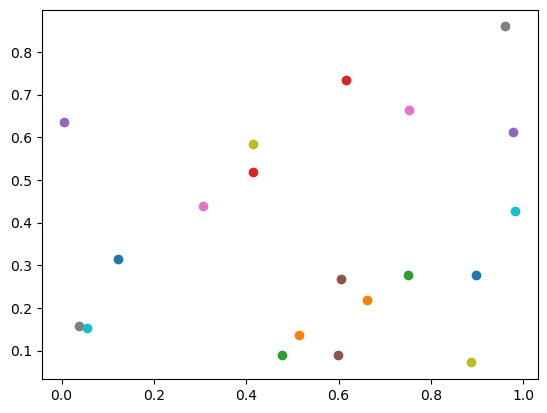

In [150]:
NUM_CIDADES = 20
NUM_INDIVIDUOS = 10

X, Y = criar_cidades(NUM_CIDADES)
plot_cidades(X, Y)
dist = get_distance_table(NUM_CIDADES, X, Y)

In [151]:
# LOOP DE EVOLUCAO
ncam = make_caminhos(NUM_CIDADES, NUM_INDIVIDUOS)
apt = get_aptidao(N=NUM_CIDADES, numero_individuos=NUM_INDIVIDUOS, numero_caminhos=ncam, distance_table=dist)

In [152]:
apt

array([ 9.49439257,  9.62483006, 11.14392716, 10.67435255, 10.1817901 ,
       10.48699205,  9.03568749,  8.87533872, 10.8839942 , 10.94067257])

In [153]:
print(tabulate(ncam, tablefmt='grid'))

+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|  0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  8 |  9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|  9 |  0 | 19 | 13 |  4 |  6 |  2 | 11 |  5 |  7 |  1 | 14 | 16 |  8 | 10 | 15 | 12 | 18 |  3 | 17 |
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
| 18 |  1 | 10 | 16 |  5 |  6 |  3 | 11 |  0 | 19 |  4 | 12 |  8 | 15 |  9 |  7 |  2 | 17 | 14 | 13 |
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|  4 |  5 | 18 | 15 |  3 | 14 |  0 | 16 | 19 |  8 | 17 |  1 |  9 | 12 |  7 |  2 | 13 | 11 |  6 | 10 |
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|  0 |  5 |  2 |  3 | 14 |  4 |  6 |  9 | 12 |  1 | 11 |  8 |  7 | 15 | 10 | 17 | 

In [154]:
# escolher os pais dessa geracao com base na aptidão
pais = get_pais(aptidao=apt, numero_caminhos=ncam)
print(pais)

[array([ 4, 11, 17, 12, 19,  0,  1, 16,  3,  6,  8,  5, 13,  2, 10,  9, 18,
       15, 14,  7], dtype=int16), array([ 5,  8,  6,  3, 11,  9,  2, 12,  7, 10, 18, 19,  1, 13,  0, 14, 15,
        4, 17, 16], dtype=int16)]


A escolha com base na aptidão está **ok**


**Mutação**

*exemplo de reciprocal exchange*

In [155]:
print(pais[0])
f1 = reciprocal_exchange(pais[0])
print(f1)

[ 4 11 17 12 19  0  1 16  3  6  8  5 13  2 10  9 18 15 14  7]
[ 4 11 17  2 19  0  1 16  3  6  8  5 13 12 10  9 18 15 14  7]


trocou  2 -> 12

In [156]:
print(pais[1])
f2 = reciprocal_exchange(pais[1])
print(f2)

[ 5  8  6  3 11  9  2 12  7 10 18 19  1 13  0 14 15  4 17 16]
[ 5  8  6  3 11  9 16 12  7 10 18 19  1 13  0 14 15  4 17  2]


trocou 2 -> 16

*exemplo de inversão* 


In [157]:
print("Antes da inversão =", f1)
f1 = tools.mutInversion(f1)

print("Depois da inversão =", f1)

Antes da inversão = [ 4 11 17  2 19  0  1 16  3  6  8  5 13 12 10  9 18 15 14  7]
Depois da inversão = (array([ 4, 11, 17,  2, 19,  0,  1, 16,  3, 18,  9, 10, 12, 13,  5,  8,  6,
       15, 14,  7], dtype=int16),)


inverteu a sequência [6, 8, 5, 13, 12, 10, 9, 18]